# Trabajo Práctico Nro 1 - Redes Neuronales, ITBA 2023
Autor: Pablo Smolkin

Legajo 59523
***

## Problema de Clasificación 

Se utilizará el dataset de Fashion MNIST, que se encuentra en la [competencia de Kaggle](https://www.kaggle.com/t/5f2641ef201d4e8aa500d4876fb2b64e) que quedará abierta hasta el final de la cursada y otorgará puntos extras a los grupos ganadores. La competencia puede hacerse por grupos (la cantidad de integrantes que se deseen pero se reparten los puntos al final). La entrega del TP es individual.

### Imports

In [1]:
from mlp_helper import *

### Load Dataset

In [2]:
x_data, y_data, class_names = load_fmnist_data()

x data Shape: (60000, 28, 28)
y data Shape: (60000,)


##### Old cell testing

### 1. **EDA:** 
Visualizar algunas instancias de cada clase. Hacer histogramas de la distribución de intensidades para cada clase, cualquier otra propuesta es bienvenida.

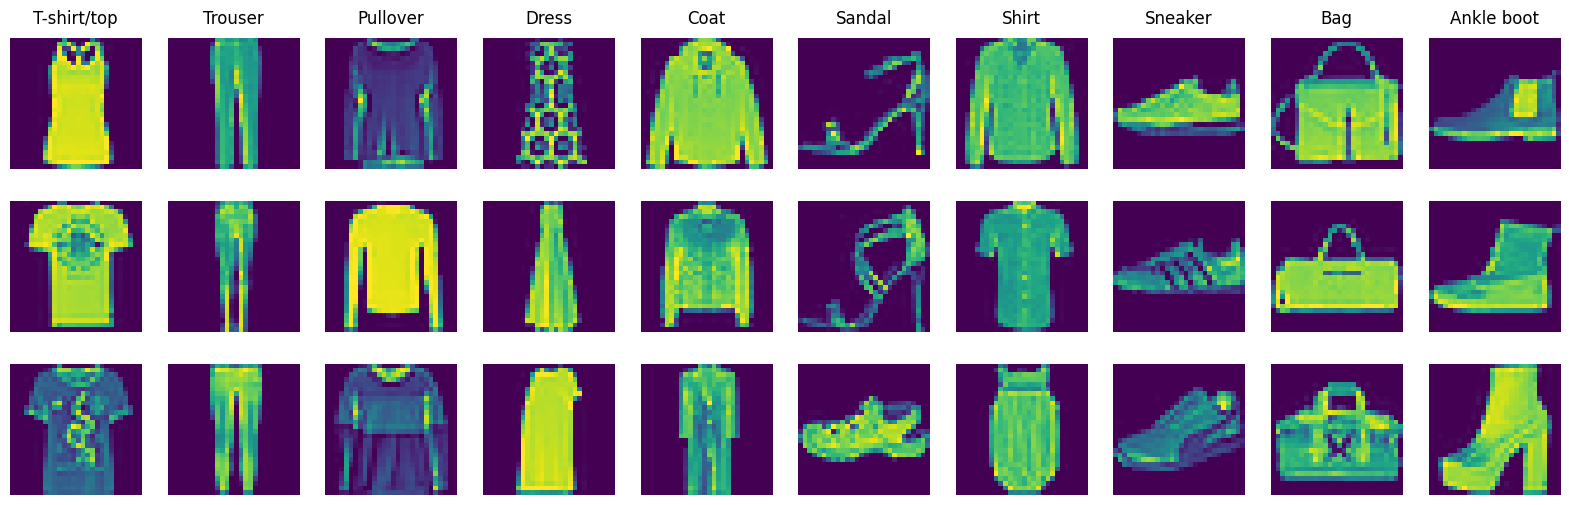

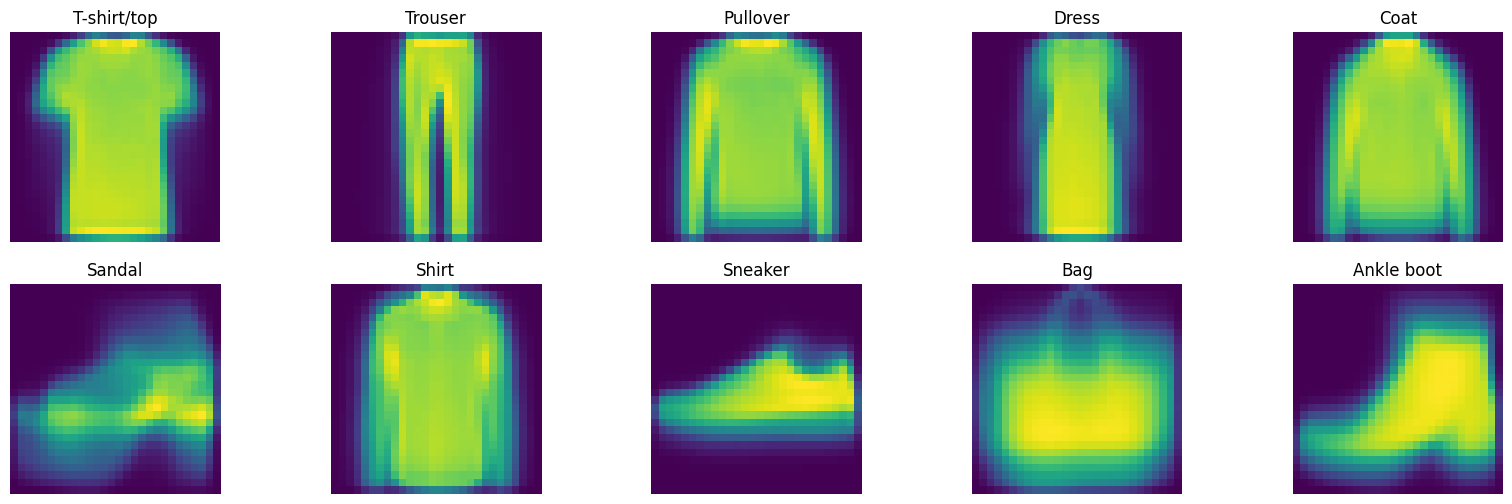

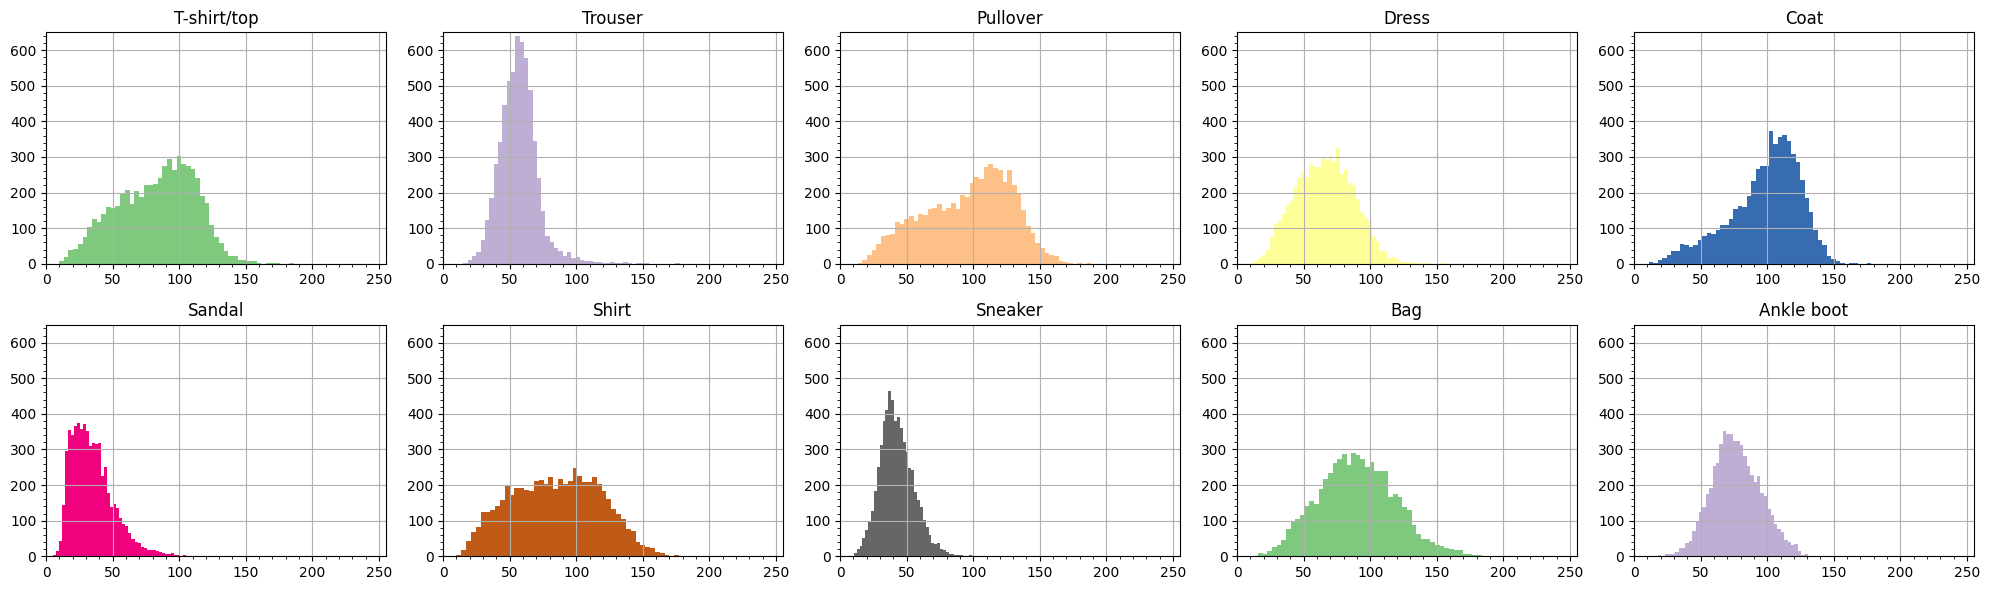

In [3]:
fmnist_eda_plots(x_data, y_data, class_names)

### 2. **Modelos:** 
Entrenar un modelo de clasificación en las 10 clases de Fashion MNIST. Regresión softmax y MLP. En el caso que corresponda probar y comparar: distintas funciones de activación, distintos optimizadores, distintas funciones de costo, distintos tamaños de red (cantidad de capas y tamaño de cada capa), learning rate, batch_size, dropout rates, batch_normalization (si/no), inicializaciones de pesos (glorot_uniform, glorot_normal, normal(0,1), normal(0,0.001)).

Métricas a reportar para cada entrenamiento de interés: Accuracy como métrica principal.
Como métricas secundarias: curva ROC, área bajo la curva ROC, F1-score, Precisión y
Recall. Enunciar para el F1-score y el área bajo la curva ROC cómo se calculan los
promedios macro y micro. Justificar cuál de los dos es el que corresponde reportar en este
problema.

Para un buen modelo obtenido en el punto anterior (así si lo mejoran no tienen que repetir
este punto), variar los hiperparámetros de a uno y graficar:

* Accuracy vs [LEARNING_RATE, BATCH_SIZE, OPTIMIZADORES, ACTIVACIONES, DROPOUT_RATE, BATCH_NORMALIZATION, INICIALIZACIONES DE PESOS]

* Iteraciones de entrenamiento vs [LEARNING_RATE, BATCH_SIZE, OPTIMIZADORES, ACTIVACIONES, DROPOUT_RATE, BATCH_NORMALIZATION, INICIALIZACIONES DE PESOS]

Intente justificar los gráficos obtenidos. Valores mínimos esperados para cada modelo: SoftmaxReg: .70, MLP: .83

### Mejor Modelo Obtenido con Softmax

In [ ]:
softReg, x_train, x_valid, y_train, y_valid = create_fmnist_model(
    x_data,
    y_data,
    metrics=['accuracy','AUC','Precision','Recall'],
    loss='mean_squared_error',
    weight_initializer='glorot_normal',
    optimizer='Adam',
    learning_rate=0.0001,
    train_valid_proportion=1/3,
    random_state_seed=10,
    verbose=False
)

history, metrics_df, id = run_model(
    model=softReg,
    x_train=x_train,
    x_valid=x_valid,
    y_train=y_train,
    y_valid=y_valid,
    batch_size=32,
    max_epochs=100,
    es_config = {
        'monitor': 'val_accuracy',
        'patience': 10,
        'mode': 'max',
        'restore_best_weights': True
    },
    show_metrics=True,
    verbose=False
)

print(f'Model ID: {id}')

              train       val
accuracy   0.886850  0.857500
auc        0.987619  0.984487
f1         0.888321  0.855448
loss       0.017692  0.021183
precision  0.909287  0.880603
recall     0.864800  0.836000
Model ID: 20230521-222644


ID: 20230521-222644, Validation accuracy: 0.8575000166893005

### Mejor Modelo conseguido de forma burda, MLP

In [ ]:
model, x_train, x_valid, y_train, y_valid = create_fmnist_model(
    x_data,
    y_data,
    metrics=['accuracy','AUC','Precision','Recall'],
    loss='categorical_crossentropy',
    hidden_layers=1,
    hidden_units=[512],
    weight_initializer='glorot_normal',
    optimizer='Adam',
    learning_rate=0.0001,
    batch_normalization=False,
    dropout_rate=0.3,
    train_valid_proportion=1/3,
    random_state_seed=10,
    verbose=False
)

history, metrics_df, id = run_model(
    model=model,
    x_train=x_train,
    x_valid=x_valid,
    y_train=y_train,
    y_valid=y_valid,
    batch_size=32,
    max_epochs=100,
    es_config = {
        'monitor': 'val_accuracy',
        'patience': 10,
        'mode': 'max',
        'restore_best_weights': True
    },
    show_metrics=True,
    verbose=False
)

print(f'Model ID: {id}')

              train       val
accuracy   0.979875  0.900150
auc        0.999743  0.987080
f1         0.992925  0.899459
loss       0.060542  0.395815
precision  0.982117  0.906094
recall     0.977575  0.897350
Model ID: 20230527-165553


ID: 20230527-165553, Validation accuracy: 0.9001500010490417

#### Learning Rate Sweep

In [4]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
accuracy_arr_lr, val_accuracy_arr_lr, iterations_arr_lr = get_plot_data_vs_param(x_data=x_data, y_data=y_data, param_name='learning_rate', param_data=learning_rates) 
np.save('plotting_data/lr', [learning_rates, accuracy_arr_lr, val_accuracy_arr_lr, iterations_arr_lr])

#### Batch Size Sweep

In [5]:
batch_sizes = [8, 16, 32, 64, 128, 256, 512]
accuracy_arr_bs, val_accuracy_arr_bs, iterations_arr_bs = get_plot_data_vs_param(x_data=x_data, y_data=y_data, param_name='batch_size', param_data=batch_sizes)
np.save('plotting_data/bs', [batch_sizes, accuracy_arr_bs, val_accuracy_arr_bs, iterations_arr_bs])

#### Optimizer Sweep

In [6]:
optimizers = ['SGD', 'RMSprop', 'Adam']
accuracy_arr_opt, val_accuracy_arr_opt, iterations_arr_opt = get_plot_data_vs_param(x_data=x_data, y_data=y_data, param_name='optimizer', param_data=optimizers)
np.save('plotting_data/opt', [optimizers, accuracy_arr_opt, val_accuracy_arr_opt, iterations_arr_opt])

#### Activation Function Sweep

In [7]:
activators = ['relu', 'leaky_relu', 'sigmoid', 'tanh']
accuracy_arr_act, val_accuracy_arr_act, iterations_arr_act = get_plot_data_vs_param(x_data=x_data, y_data=y_data, param_name='activation', param_data=activators)
np.save('plotting_data/act', [activators, accuracy_arr_act, val_accuracy_arr_act, iterations_arr_act])

#### Dropout Rate Sweep

In [8]:
dropout_rates = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
accuracy_arr_dr, val_accuracy_arr_dr, iterations_arr_dr = get_plot_data_vs_param(x_data=x_data, y_data=y_data, param_name='dropout_rate', param_data=dropout_rates)
np.save('plotting_data/dr', [dropout_rates, accuracy_arr_dr, val_accuracy_arr_dr, iterations_arr_dr])

#### Batch Normalization Y/N

In [9]:
batch_normalizations = [False, True]
accuracy_arr_bn, val_accuracy_arr_bn, iterations_arr_bn = get_plot_data_vs_param(x_data=x_data, y_data=y_data, param_name='batch_normalization', param_data=batch_normalizations)
np.save('plotting_data/bn', [batch_normalizations, accuracy_arr_bn, val_accuracy_arr_bn, iterations_arr_bn])

#### Weight Initialization Sweep

In [10]:
weight_initializers = ['glorot_normal', 'glorot_uniform', 'random_normal', 'random_uniform']
accuracy_arr_wi, val_accuracy_arr_wi, iterations_arr_wi = get_plot_data_vs_param(x_data=x_data, y_data=y_data, param_name='weight_initializer', param_data=weight_initializers)
np.save('plotting_data/wi', [weight_initializers, accuracy_arr_wi, val_accuracy_arr_wi, iterations_arr_wi])

d:\VSCodeRepos\RN-TP1\venv\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


#### Loss Function Sweep

In [11]:
losses = ['categorical_crossentropy', 'mse', 'mae']
accuracy_arr_loss, val_accuracy_arr_loss, iterations_arr_loss = get_plot_data_vs_param(x_data=x_data, y_data=y_data, param_name='loss', param_data=losses)
np.save('plotting_data/loss', [losses, accuracy_arr_loss, val_accuracy_arr_loss, iterations_arr_loss])

### Plotting sweep results

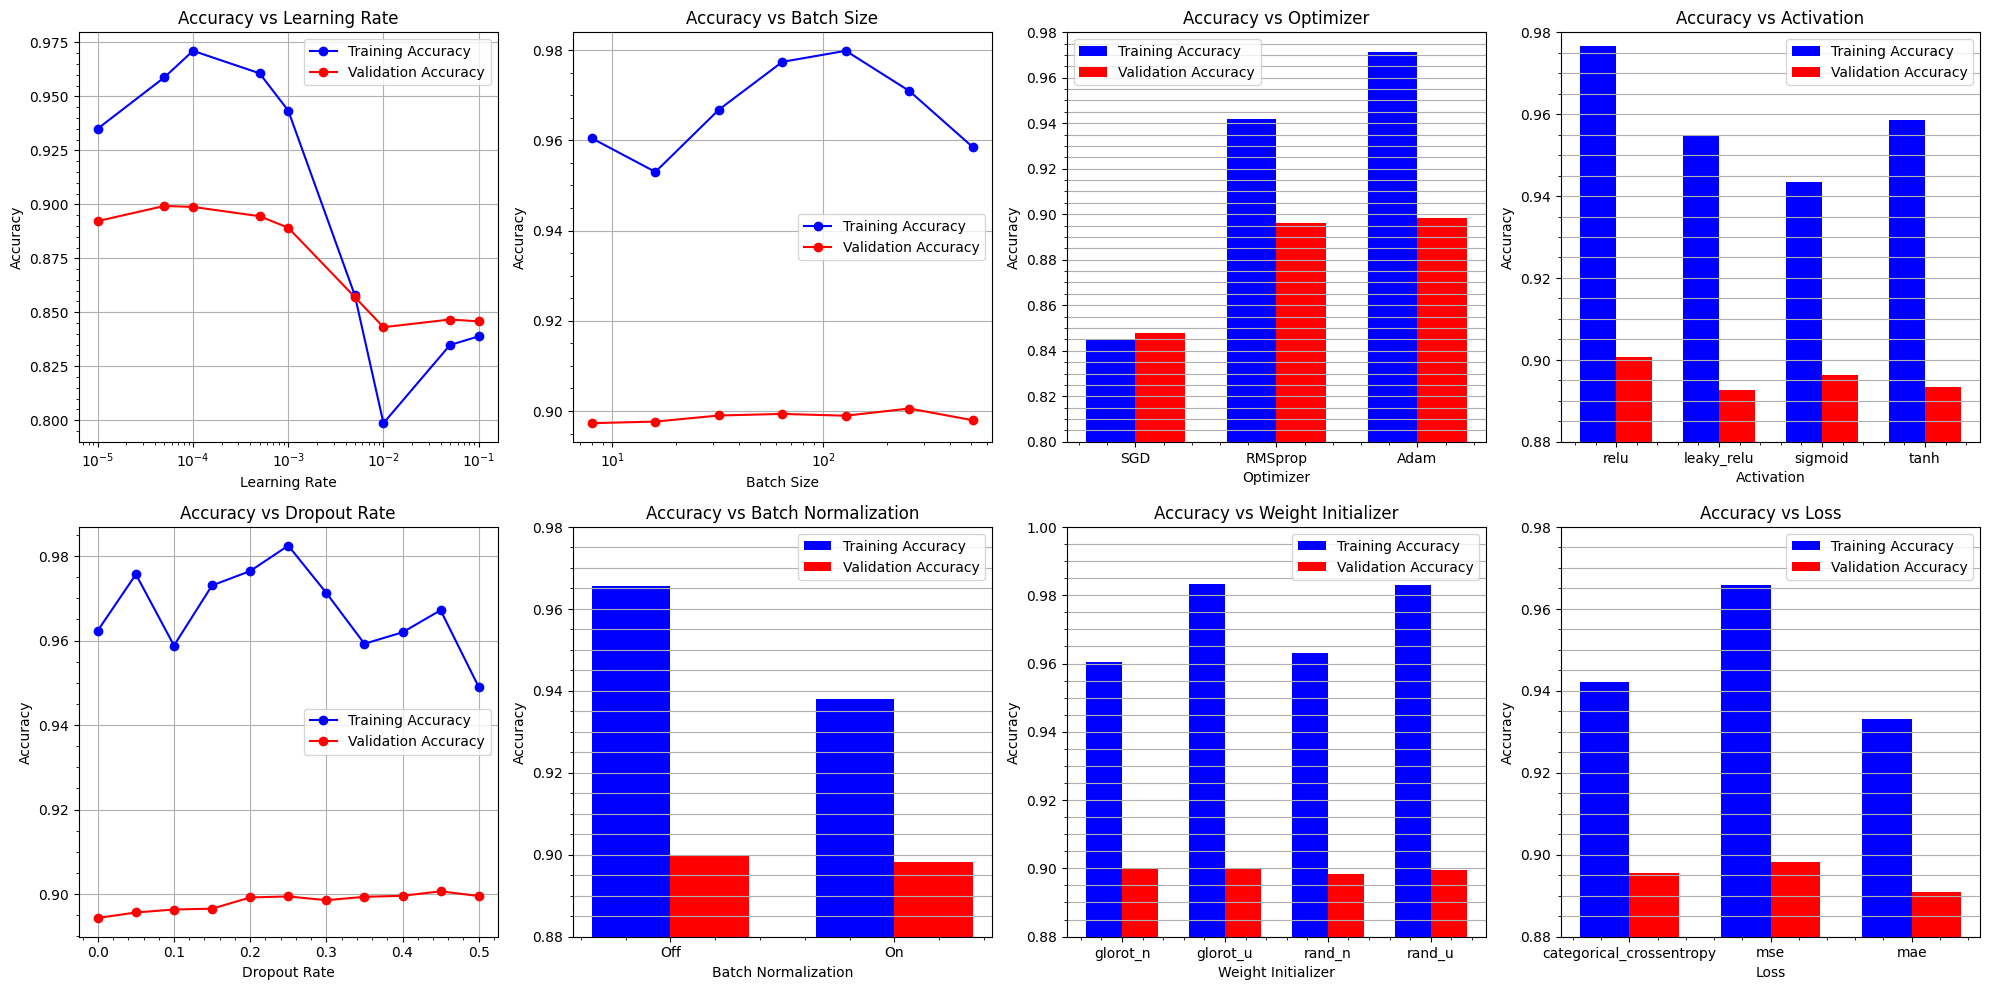

In [2]:
plot_sweep_results(metric='Accuracy')

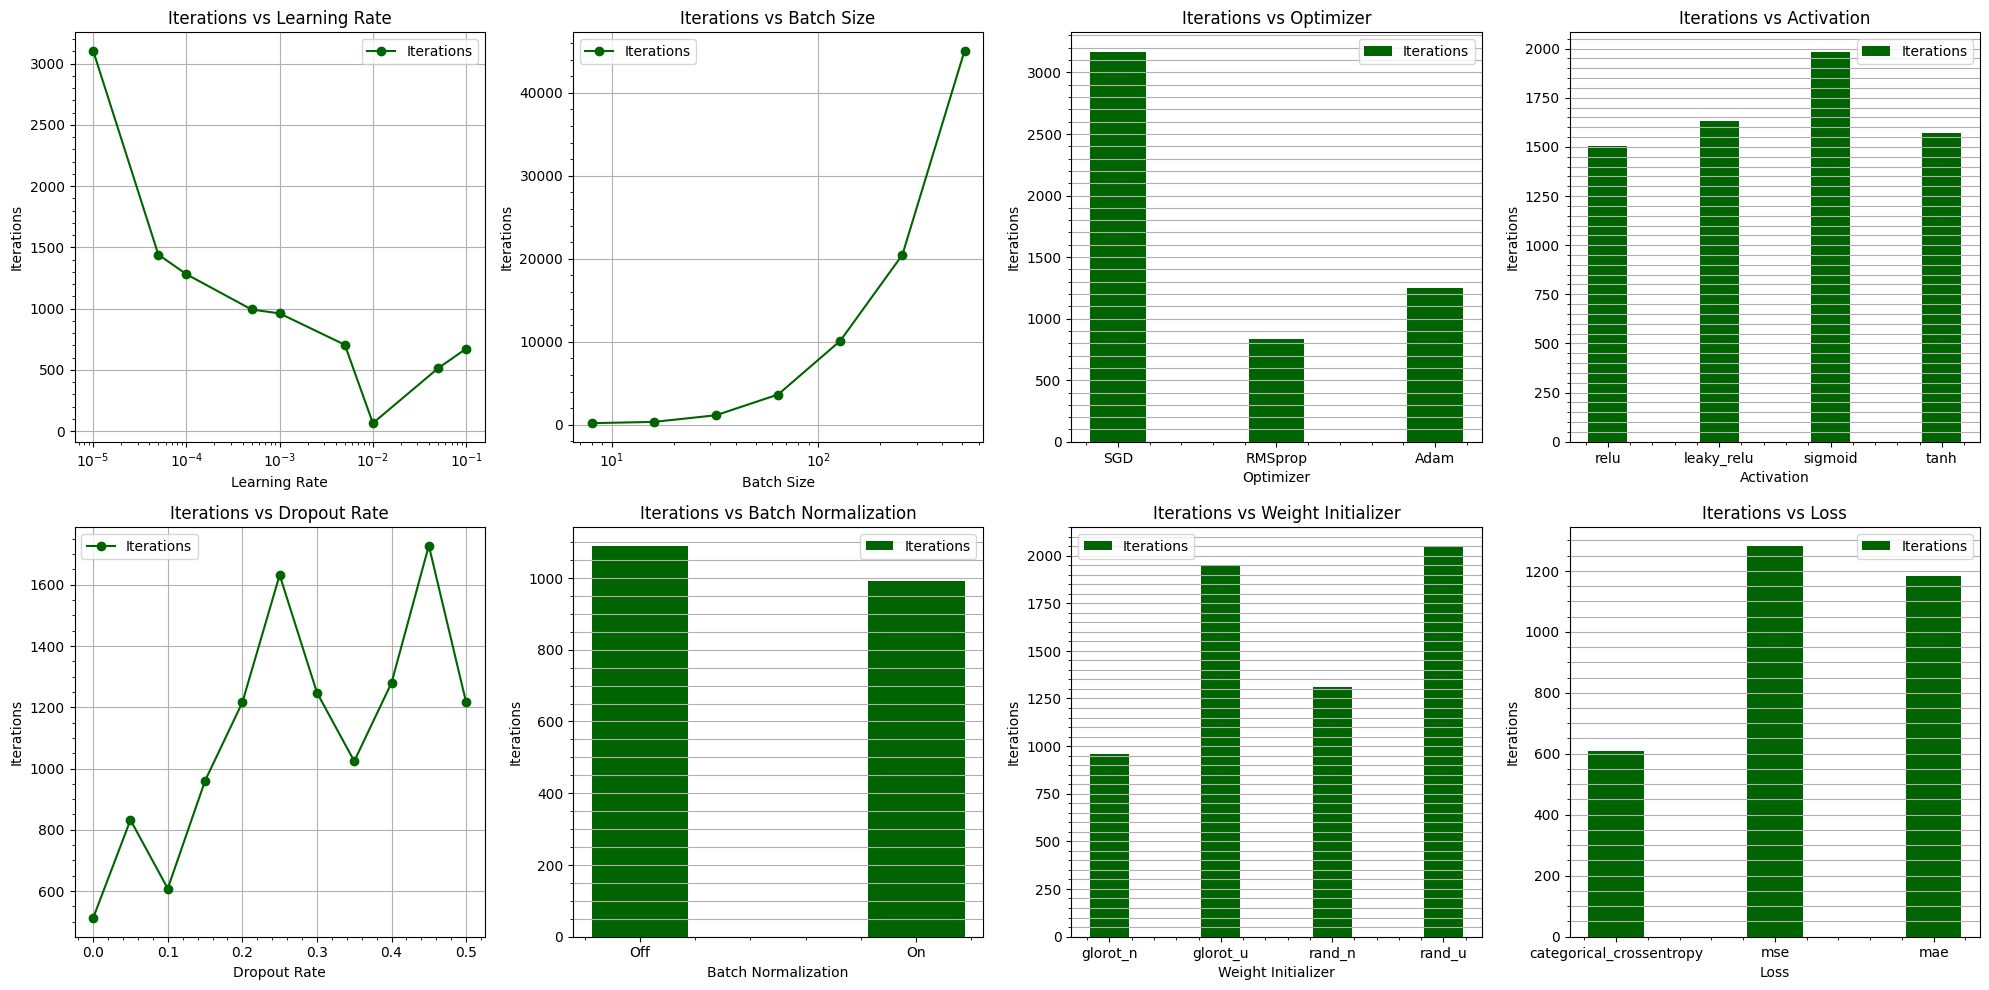

In [3]:
plot_sweep_results(metric='Iterations')

### 3. 
El mejor modelo debe ser reentrenado agregando una capa de tamaño 2 antes de la de salida. Mapear los datos de entrada a la salida de la capa agregada y graficarla con los labels correspondientes. Superponer en el mismo gráfico los umbrales de decisión. Para obtener los umbrales de decisión se debe armar una grilla de puntos que debe darse como input a la última capa de la red neuronal (softmax) y tomar el argumento máximo como clase correspondiente.
   
Se alienta a intentar aumentar los datos de entrenamiento haciendo espejamiento de las imágenes en las situaciones que tenga sentido hacerlo. 

Una vez entregado el TP se pueden seguir subiendo predicciones de modelos nuevos a Kaggle hasta el final de la cursada.

In [3]:
model, x_train, x_valid, y_train, y_valid = create_fmnist_model(
    x_data,
    y_data,
    metrics=['accuracy','AUC','Precision','Recall'],
    loss='categorical_crossentropy',
    hidden_layers=1,
    hidden_units=[512],
    weight_initializer='glorot_normal',
    optimizer='Adam',
    learning_rate=0.0001,
    batch_normalization=False,
    dropout_rate=0.45,
    feature_layer=True,
    train_valid_proportion=1/3,
    random_state_seed=10,
    verbose=False
)

history, metrics_df, id = run_model(
    model=model,
    x_train=x_train,
    x_valid=x_valid,
    y_train=y_train,
    y_valid=y_valid,
    batch_size=32,
    max_epochs=100,
    es_config = {
        'monitor': 'val_accuracy',
        'patience': 10,
        'mode': 'max',
        'restore_best_weights': True
    },
    show_metrics=True,
    verbose=False
)

                  train          val
accuracy       0.922775     0.865050
auc            0.995939     0.982542
f1             0.950960     0.865260
iterations  2496.000000  2496.000000
loss           0.238337     0.513606
precision      0.933054     0.879137
recall         0.913250     0.853950


In [120]:
# Extract features from the hidden layer with 2 neurons for validation set
features_val = extract_features(model, x_valid)

625/625 [==============================] - 1s 2ms/step


In [129]:
xx, yy, boundaries = get_boundary_predictions(model)

313/313 [==============================] - 0s 856us/step


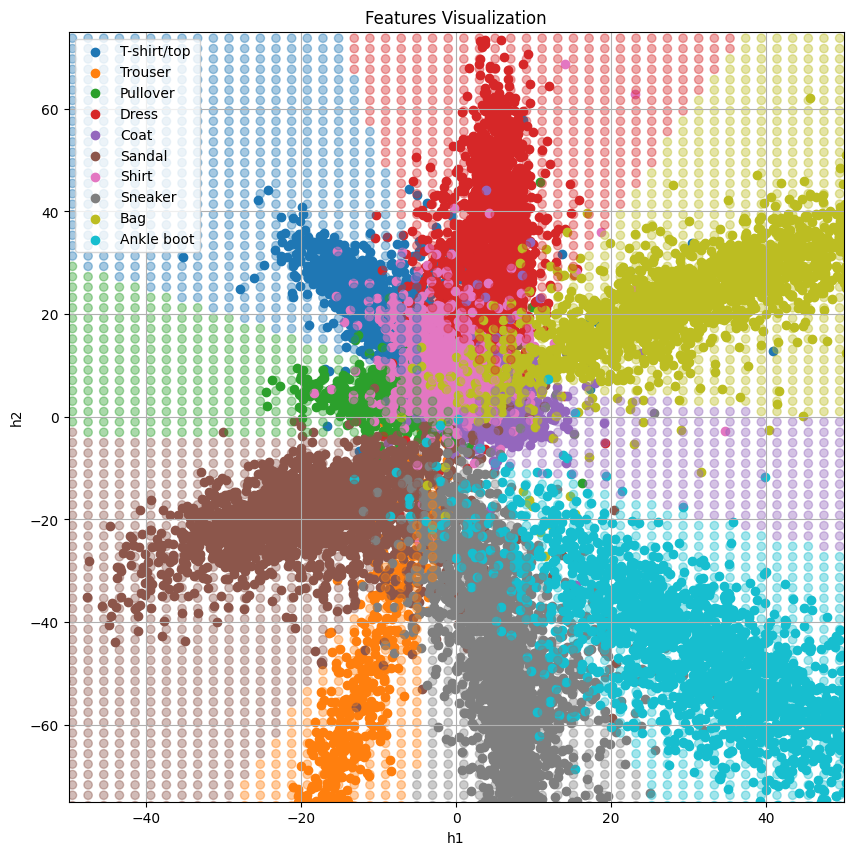

In [130]:
visualize_features(features_val, y_valid, xx, yy, boundaries)

***

## Problema de Regresión

***

## Testing Code

In [ ]:
x_data = np.load('../AssignmentGoodies/train_images.npy')
print(x_data.shape)

y_data = pd.read_csv('../AssignmentGoodies/train_labels.csv').to_numpy()[:,0]
print(y_data.shape)

In [ ]:
y_data.shape

In [ ]:
y_data[0]

In [ ]:
plt.imshow(x_data[0,...])

In [ ]:
from sklearn import model_selection

In [ ]:
# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_data, y_data, test_size=1/3, random_state=10, shuffle=True)

In [ ]:
x_train, x_valid = x_train / 255.0, x_valid / 255.0

In [ ]:
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

In [ ]:
y_sparse_train = np.zeros([40000,10])
y_sparse_valid = np.zeros([20000,10])

In [ ]:
for idx in range(40000):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(20000):
    y_sparse_valid[idx,y_valid[idx]] = 1

In [ ]:
y_sparse_train[0]

In [ ]:
y_sparse_valid[0]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model =  Sequential()

In [ ]:
model.add(Flatten(input_shape=(28,28)))

In [ ]:
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer=Adam(learning_rate=0.0001),metrics=["accuracy"])

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
history = model.fit(x= x_train, y = y_sparse_train, validation_data=(x_valid, y_sparse_valid), batch_size = 32, epochs=100, callbacks=[earlyStopping])

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()
maxAccuracy = max(history.history["accuracy"])
maxValAccuracy = max(history.history["val_accuracy"])
print(f"Max Accuracy: {maxAccuracy:.4f}")
print(f"Max Val Accuracy: {maxValAccuracy:.4f}")

### Con Conv2D

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import model_selection

fashion_mnist = np.load('../AssignmentGoodies/train_images.npy')
print(fashion_mnist.shape)
x_data = fashion_mnist
y_data = pd.read_csv('../AssignmentGoodies/train_labels.csv').to_numpy()[:,0]
print(y_data.shape)

# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_data, y_data, test_size=1/3, random_state=10, shuffle=True)

x_train, x_valid = x_train / 255.0, x_valid / 255.0

y_sparse_train = np.zeros([40000,10])
y_sparse_valid = np.zeros([20000,10])

for idx in range(40000):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(20000):
    y_sparse_valid[idx,y_valid[idx]] = 1

model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=(28,28,1)))
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(128, activation="relu", kernel_initializer="glorot_normal"))
model.add(Dense(10, activation="softmax", kernel_initializer="glorot_normal"))

model.compile(loss = "categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, amsgrad=True),metrics=["accuracy"])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

In [ ]:
history = model.fit(x= x_train, y = y_sparse_train, validation_data=(x_valid, y_sparse_valid), batch_size = 32, epochs=100, callbacks=[earlyStopping])

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()
maxAccuracy = max(history.history["accuracy"])
maxValAccuracy = max(history.history["val_accuracy"])
print(f"Max Accuracy: {maxAccuracy:.4f}")
print(f"Max Val Accuracy: {maxValAccuracy:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

x_train_c = x_train[..., tf.newaxis]
x_valid_c = x_valid[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train_c, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_valid_c, y_valid)).batch(32)

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


EPOCHS = 30

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))